# Predicting fare_amount
- Attempting to predict the fare amount from the available data such as trip distance, pickup locations, etc
- Anaconda python2 environment

In [58]:
!pip install pygeohash

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pygeohash as gh
%matplotlib inline

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import ensemble

In [61]:
df = pd.read_csv('data.csv')
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount
0,2,2015-07-18 11:25:58,2015-07-18 11:43:47,1,7.21,-73.862762,40.769028,1.0,N,-73.949203,40.722584,1,22.5,0.0,0.5,4.66,0.00,0.3,27.96
1,1,2015-03-15 12:50:01,2015-03-15 13:23:35,1,10.80,-73.870926,40.773727,NaN,N,-73.988228,40.765694,1,34.5,0.0,0.5,8.10,5.33,0.3,48.73
2,2,2015-04-30 12:25:44,2015-04-30 13:03:51,1,4.28,-73.978180,40.762341,NaN,N,-74.008911,40.710789,1,24.5,0.0,0.5,2.50,0.00,0.3,27.80
3,2,2015-05-28 08:47:56,2015-05-28 09:26:08,1,18.47,-73.776711,40.645302,NaN,N,-73.843422,40.852852,1,51.0,0.0,0.5,7.00,5.54,0.3,64.34
4,1,2015-06-20 19:36:17,2015-06-20 20:10:49,1,15.50,-73.777054,40.644947,NaN,Y,-73.946800,40.725021,1,44.5,0.0,0.5,9.06,0.00,0.3,54.36


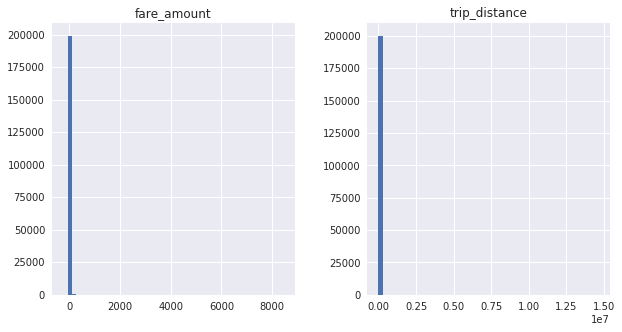

In [62]:
# Check the distribution of trip_distance and fare_amount
df[['trip_distance','fare_amount']].hist(figsize = (10,5), bins=50);

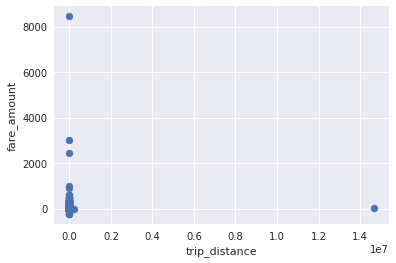

In [63]:
# Check the correlation between trip_distance and fare_amount
plt.scatter(df['trip_distance'], df['fare_amount'])
plt.xlabel('trip_distance')
plt.ylabel('fare_amount');

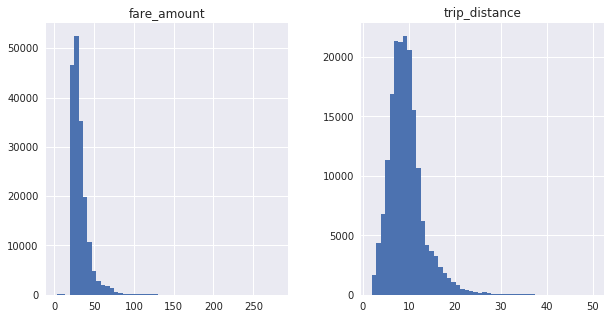

In [64]:
# Remove those outliers with very low or very high trip_distance or fare_amount 
df_filtered = df[(df['trip_distance'] >= 2) & (df['trip_distance'] <= 50) & (df['fare_amount'] >= 3) & (df['fare_amount'] <=300)]
df_filtered[['trip_distance','fare_amount']].hist(figsize = (10,5), bins=50);

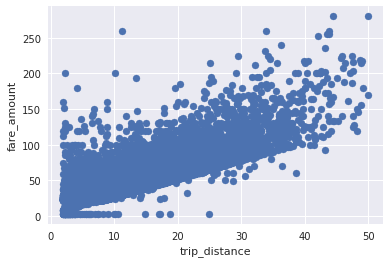

In [65]:
# Check the correlation between trip_distance and fare_amount to see if outliers are removed
plt.scatter(df_filtered['trip_distance'], df_filtered['fare_amount'])
plt.xlabel('trip_distance')
plt.ylabel('fare_amount');

/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

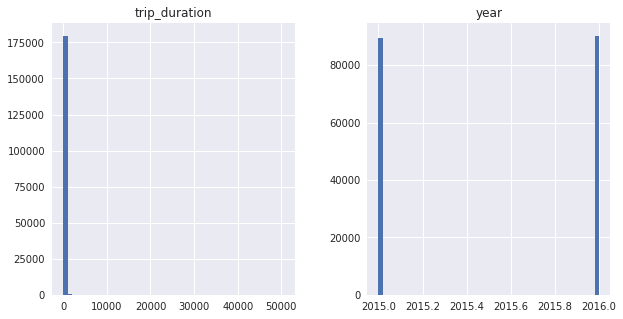

In [68]:
# Calculate trip_duration and year
df_filtered['pickup_datetime'] = pd.to_datetime(df_filtered['pickup_datetime'])
df_filtered['dropoff_datetime'] = pd.to_datetime(df_filtered['dropoff_datetime'])
df_filtered['trip_duration'] = (df_filtered['dropoff_datetime']-df_filtered['pickup_datetime']).dt.total_seconds()/60
df_filtered['year'] = df_filtered['pickup_datetime'].dt.year
df_filtered[['trip_duration', 'year']].hist(figsize = (10,5), bins=50);

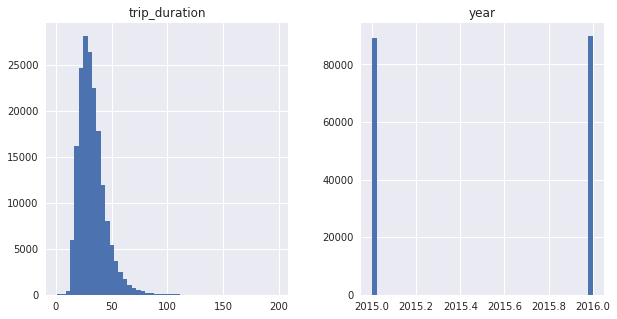

In [69]:
# Remove those outliers with very low or very high trip_duration 
df_filtered = df_filtered[(df_filtered['trip_duration'] <= 200) & (df_filtered['trip_duration'] > 1)]
df_filtered[['trip_duration', 'year']].hist(figsize = (10,5), bins=50);

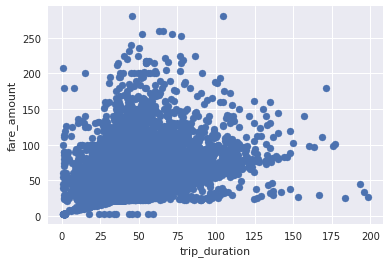

In [72]:
# Check the correlation between trip_duration and fare_amount to see if outliers are removed
plt.scatter(df_filtered['trip_duration'], df_filtered['fare_amount'])
plt.xlabel('trip_duration')
plt.ylabel('fare_amount');

In [73]:
# Define some helper functions
def train_test_split(X, y):
    """Split X and y into training set and testing set.
    Data from year = 2015 is used as training set while data from year = 2016 is used as testing set.
    Returns X_train, y_train, X_test, y_test
    """
    
    X_train = X.loc[X['year'] == 2015].drop('year', axis=1)
    y_train = y.loc[y['year'] == 2015].drop('year', axis=1).values.ravel()
    X_test = X.loc[X['year'] == 2016].drop('year', axis=1)
    y_test = y.loc[y['year'] == 2016].drop('year', axis=1).values.ravel()
    return X_train, y_train, X_test, y_test
  
def model_results(X_train, y_train, X_test, y_test, model):
    """Print model parameters of RMSE and R-square on training and testing sets.
    """
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print("----Training Data results (2015 data set)----")
    print("RMSE: ${:.1f}".format(mean_squared_error(y_train, y_train_pred)**0.5))
    print("R2: {:.2f}\n".format(r2_score(y_train, y_train_pred)))
    
    print("----Test Data results (2016 data set)----")
    print("RMSE: ${:.1f}".format(mean_squared_error(y_test, y_test_pred)**0.5))
    print("R2: {:.2f}\n".format(r2_score(y_test, y_test_pred)))

In [15]:
# Create Train and Test sets
y = df_filtered[['fare_amount', 'year']]
X = df_filtered[['trip_distance', 'trip_duration', 'year']]
X_train, y_train, X_test, y_test = train_test_split(X, y)

In [16]:
X_train.head()

,trip_distance,trip_duration
0,7.21,17.816667
1,10.80,33.566667
2,4.28,38.116667
3,18.47,38.200000
4,15.50,34.533333


# Simple Intuitive model
- Intuitively, the fare amount depends on distance traveled as well as travel time
- Build a simple bivariate linear model to include these 2 features only

In [17]:
# Simple bivariate model
lm = LinearRegression().fit(X_train,y_train)
model_results(X_train, y_train, X_test, y_test, lm)

----Training Data results (2015 data set)----
RMSE: $5.6
R2: 0.79

----Test Data results (2016 data set)----
RMSE: $5.5
R2: 0.81



# Simple Intuitive model results
- Simple bivariate linear model has a high RMSE as 5.5
- Try multivariate linear model to reduce the RMSE

# Feature Engineering
Add in features as below
1. Pickup month
2. Pickup day of the week
3. Pickup hour of the day
4. Lattitude difference
5. Longitude difference
6. Geohashed pickup location (idea from internet)
7. Geohashed dropoff location (idea from internet)

In [18]:
# Create new features as mentioned above
df_filtered['day'] = df_filtered['pickup_datetime'].dt.day
df_filtered['month'] = df_filtered['pickup_datetime'].dt.month
df_filtered['day_of_week'] = df_filtered['pickup_datetime'].dt.weekday_name
df_filtered['hour_of_day'] = df_filtered['pickup_datetime'].dt.hour
df_filtered['lat_dif'] = df_filtered['pickup_latitude'] - df_filtered['dropoff_latitude']
df_filtered['lon_dif'] = df_filtered['pickup_longitude'] - df_filtered['dropoff_longitude']
df_filtered['pickup_geohash']=df_filtered.apply(lambda x: gh.encode(x.pickup_latitude, x.pickup_longitude, precision=5), axis=1)
df_filtered['dropoff_geohash']=df_filtered.apply(lambda x: gh.encode(x.dropoff_latitude, x.dropoff_longitude, precision=5), axis=1)

df_filtered.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,...,trip_duration,year,day,month,day_of_week,hour_of_day,lat_dif,lon_dif,pickup_geohash,dropoff_geohash
0,2,2015-07-18 11:25:58,2015-07-18 11:43:47,1,7.21,-73.862762,40.769028,1.0,N,-73.949203,...,17.816667,2015,18,7,Saturday,11,0.046444,0.086441,dr5rz,dr5rt
1,1,2015-03-15 12:50:01,2015-03-15 13:23:35,1,10.80,-73.870926,40.773727,NaN,N,-73.988228,...,33.566667,2015,15,3,Sunday,12,0.008034,0.117302,dr5rz,dr5ru
2,2,2015-04-30 12:25:44,2015-04-30 13:03:51,1,4.28,-73.978180,40.762341,NaN,N,-74.008911,...,38.116667,2015,30,4,Thursday,12,0.051552,0.030731,dr5ru,dr5re
3,2,2015-05-28 08:47:56,2015-05-28 09:26:08,1,18.47,-73.776711,40.645302,NaN,N,-73.843422,...,38.200000,2015,28,5,Thursday,8,-0.207550,0.066711,dr5x1,dr72r
4,1,2015-06-20 19:36:17,2015-06-20 20:10:49,1,15.50,-73.777054,40.644947,NaN,Y,-73.946800,...,34.533333,2015,20,6,Saturday,19,-0.080074,0.169746,dr5x1,dr5rt


In [19]:
df_filtered.shape

(179231, 29)

In [20]:
# Remove null values from lattitude and longitude
df_filtered = df_filtered[df_filtered['lat_dif'].notnull() & df_filtered['lon_dif'].notnull()]
df_filtered.shape

(135568, 29)

In [21]:
df_filtered.isna().sum()

vendor_id                 0
pickup_datetime           0
dropoff_datetime          0
passenger_count           0
trip_distance             0
pickup_longitude          0
pickup_latitude           0
rate_code             45595
store_and_fwd_flag        0
dropoff_longitude         0
dropoff_latitude          0
payment_type              0
fare_amount               0
extra                     0
mta_tax                   0
tip_amount                0
tolls_amount              0
imp_surcharge             0
total_amount              0
trip_duration             0
year                      0
day                       0
month                     0
day_of_week               0
hour_of_day               0
lat_dif                   0
lon_dif                   0
pickup_geohash            0
dropoff_geohash           0
dtype: int64

In [22]:
# Split response (y) and features (X)
y = df_filtered[['fare_amount', 'year']]
X = df_filtered[['passenger_count', 'trip_distance', 'trip_duration', 'year', 'month', 'day_of_week', 'hour_of_day', 'lat_dif', 'lon_dif', 'pickup_geohash']]
X_encoded = pd.get_dummies(X, columns=['month', 'day_of_week', 'hour_of_day', 'pickup_geohash'])

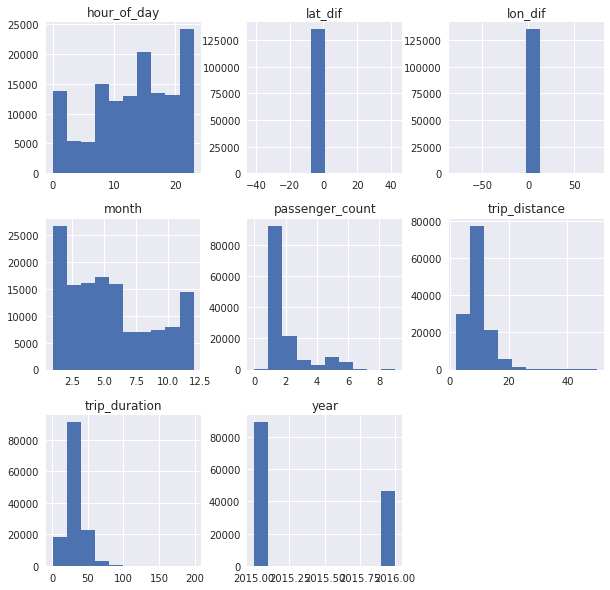

In [23]:
# Check distribution of features
X.hist(figsize = (10,10));

In [24]:
# Split Training and Testing sets
X_train, y_train, X_test, y_test = train_test_split(X_encoded, y)

In [25]:
# Multivariate Linear Model
lm = LinearRegression().fit(X_train,y_train)
model_results(X_train, y_train, X_test, y_test, lm)

----Training Data results (2015 data set)----
RMSE: $5.3
R2: 0.81

----Test Data results (2016 data set)----
RMSE: $5.1
R2: 0.83



# Feature Engineering results
- Through trial and error found that adding dropoff_geohash is leading to overfit so drop this from the features list 
- Multivariate linear model has improved the RMSE to 5.1
- Since the Training Data still has high RMSE, the linear model is suffering from high Bias
- Try Boosting models to improve the Bias

# Advanced Model

In [38]:
# Gradient boosting regressor to reduce bias
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'ls'}
gbr = ensemble.GradientBoostingRegressor(**params)
gbr.fit(X_train, y_train)
model_results(X_train, y_train, X_test, y_test, gbr)

----Training Data results (2015 data set)----
RMSE: $3.7
R2: 0.91

----Test Data results (2016 data set)----
RMSE: $3.9
R2: 0.90



In [39]:
# Define helper function
def importances(X_train, model):
    """Plots the top 20 features of importance to the model.
    """

    feature_importance = model.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[::-1][:20][::-1]
    names = [X_train.columns[index] for index in sorted_idx]
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(10,10))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, names)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.tight_layout()
    plt.show()

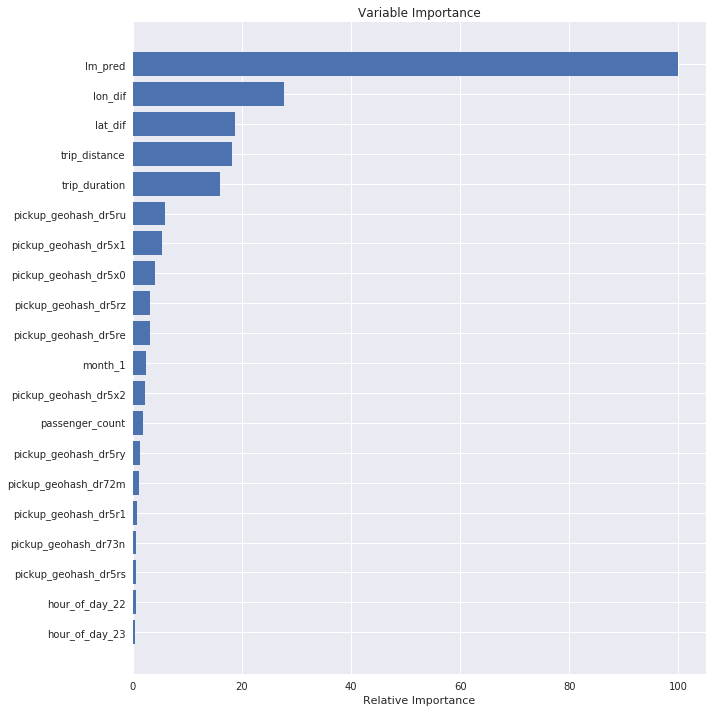

In [40]:
importances(X_train, gbr)

# Advanced Model results
- Boosting model has significantly improved the RMSE to 4
- Try Data Augmentation to drive RMSE lower

# Data Augmentation
- Weather might play a role in taxi fare
- Big Query has weather data
- Choose 1 station within new york to augment weather data to original dataset

In [41]:
# Load the weather data
weather_df = pd.read_csv('weather_data.csv')
weather_df.drop(['Unnamed: 0'], axis = 1, inplace = True)
weather_df.head()

,year,month,day,min_temp,max_temp,prcp,sndp
0,2016,4,3,35.1,61.0,0.24,999.9
1,2016,3,21,33.1,50.0,0.14,999.9
2,2016,8,5,70.0,86.0,0.00,999.9
3,2016,10,31,46.9,60.1,0.76,999.9
4,2016,3,25,44.1,73.0,0.00,999.9


In [42]:
# Merge weather data with trips data
df_augmented = df_filtered.merge(weather_df, how='inner', on = ['year', 'month', 'day'])
df_augmented.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,...,day_of_week,hour_of_day,lat_dif,lon_dif,pickup_geohash,dropoff_geohash,min_temp,max_temp,prcp,sndp
0,2,2015-07-18 11:25:58,2015-07-18 11:43:47,1,7.21,-73.862762,40.769028,1.0,N,-73.949203,...,Saturday,11,0.046444,0.086441,dr5rz,dr5rt,68.0,86.0,0.0,999.9
1,1,2015-07-18 05:45:28,2015-07-18 06:10:13,1,14.00,-74.011505,40.702785,1.0,N,-74.088554,...,Saturday,5,0.103264,0.077049,dr5re,dr5qf,68.0,86.0,0.0,999.9
2,1,2015-07-18 00:22:24,2015-07-18 00:50:07,1,6.10,-74.008011,40.741375,1.0,N,-73.963081,...,Saturday,0,-0.062584,-0.044930,dr5rg,dr72h,68.0,86.0,0.0,999.9
3,1,2015-07-18 21:58:53,2015-07-18 22:16:51,1,7.50,-73.970001,40.785599,1.0,N,-73.933266,...,Saturday,21,-0.071918,-0.036736,dr72h,dr72m,68.0,86.0,0.0,999.9
4,1,2015-07-18 11:19:37,2015-07-18 11:46:54,2,10.00,-73.862732,40.769016,1.0,N,-73.987709,...,Saturday,11,0.047882,0.124977,dr5rz,dr5rs,68.0,86.0,0.0,999.9


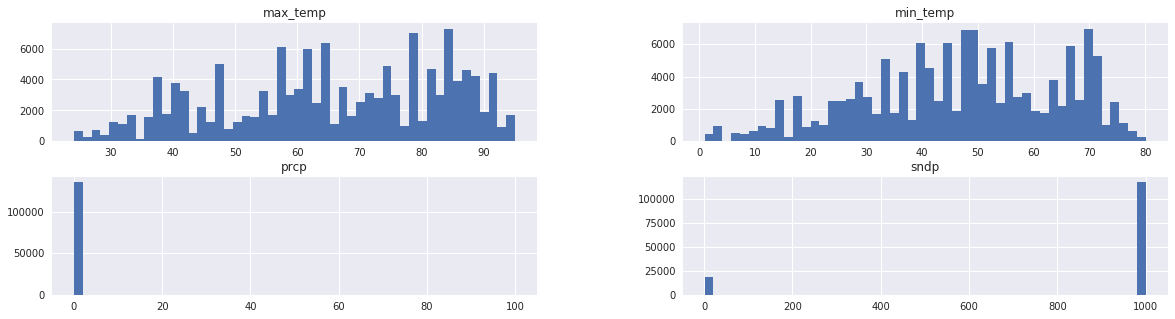

In [43]:
# Check distribution of newly appended columns
df_augmented[['min_temp','max_temp', 'prcp', 'sndp']].hist(figsize = (20,5), bins=50);

In [44]:
# prcp and sndp seem to have mainly 2 classes. Manually encode them
df_augmented['prcp_class'] = np.where(df_augmented['prcp']>=90, 'rain', 'dry')
df_augmented['sndp_class'] = np.where(df_augmented['sndp']>=900, 'snow', 'dry')

In [45]:
# Split response (y) and features (X)
y = df_augmented[['fare_amount', 'year']]
X = df_augmented[['passenger_count', 'trip_distance', 'trip_duration', 'year', 'month', 'day_of_week', 'hour_of_day', 'lat_dif', 'lon_dif', 'pickup_geohash', 'min_temp', 'max_temp', 'prcp_class', 'sndp_class']]
X_encoded = pd.get_dummies(X, columns=['month', 'day_of_week', 'hour_of_day', 'pickup_geohash', 'prcp_class', 'sndp_class'])

In [46]:
# Split Training and Testing sets
X_train, y_train, X_test, y_test = train_test_split(X_encoded, y)

In [47]:
# Gradient boosting regressor
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'ls'}
gbr = ensemble.GradientBoostingRegressor(**params)
gbr.fit(X_train, y_train)

model_results(X_train, y_train, X_test, y_test, gbr)

----Training Data results (2015 data set)----
RMSE: $3.9
R2: 0.90

----Test Data results (2016 data set)----
RMSE: $4.0
R2: 0.89



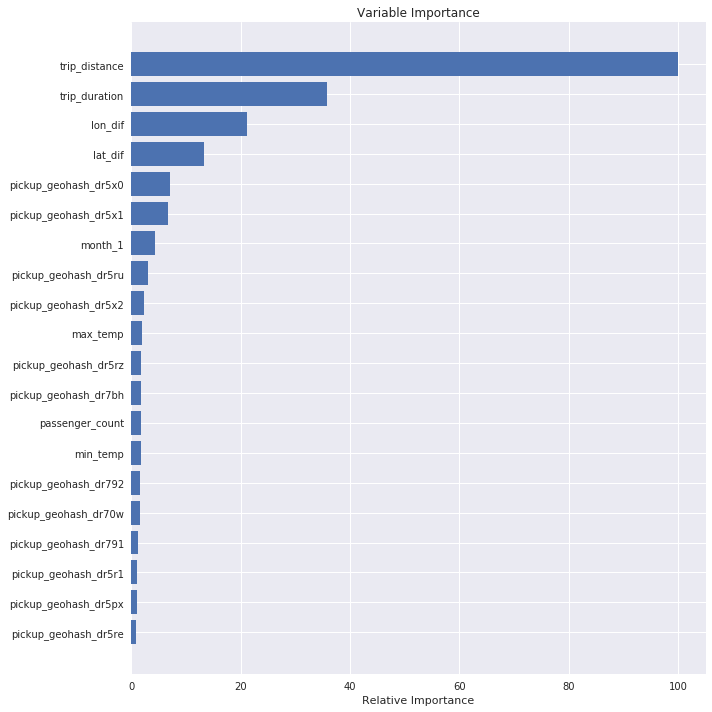

In [48]:
importances(X_train, gbr)

# Data Augmentation Results
- No difference in RMSE with additional weather features

# Hyperparameter Tuning
- Try tuning hyperparameters to reduce RMSE

In [49]:
# Split response (y) and features (X)
y = df_filtered[['fare_amount', 'year']]
X = df_filtered[['passenger_count', 'trip_distance', 'trip_duration', 'year', 'month', 'day_of_week', 'hour_of_day', 'lat_dif', 'lon_dif', 'pickup_geohash']]
X_encoded = pd.get_dummies(X, columns=['month', 'day_of_week', 'hour_of_day', 'pickup_geohash'])

In [50]:
# Split Training and Testing sets
X_train, y_train, X_test, y_test = train_test_split(X_encoded, y)

In [ ]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

parameters = {
    'learning_rate': [0.1, 0.15, 0.2],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 10],
    'max_depth':[4, 5],
    'n_estimators':[500, 1000]
    }

gbr_tuned = GridSearchCV(ensemble.GradientBoostingRegressor(), parameters, cv=5, n_jobs=4)
gbr_tuned.fit(X_train, y_train)

print(gbr_tuned.best_params_)
model_results(X_train, y_train, X_test, y_test, gbr_tuned)

In [36]:
# Best parameters from Hyperparameter tuning
params = {
    'learning_rate':0.1,
    'min_samples_split':10,
    'min_samples_leaf':10,
    'max_depth':4,
    'n_estimators':1000}
gbr_tuned = ensemble.GradientBoostingRegressor(**params)
gbr_tuned.fit(X_train, y_train)
model_results(X_train, y_train, X_test, y_test, gbr_tuned)

----Training Data results (2015 data set)----
RMSE: $2.3
R2: 0.96

----Test Data results (2016 data set)----
RMSE: $3.5
R2: 0.92



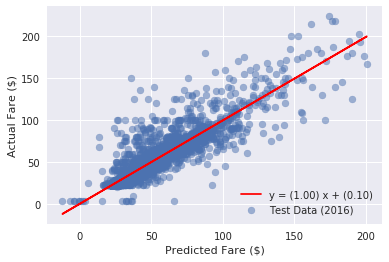

In [37]:
# Plot the Actual vs Predicted to visually check the correlation
y_train_pred = gbr_tuned.predict(X_train)
y_test_pred = gbr_tuned.predict(X_test)
test_data_fit = LinearRegression().fit(y_test_pred.reshape(-1, 1),y_test)
slope = test_data_fit.coef_[0]
intercept = test_data_fit.intercept_
line = slope * y_test_pred + intercept

#plt.scatter(y_train_pred, y_train, alpha = 0.5, label = 'Training Data (2015)')
plt.scatter(y_test_pred, y_test, alpha = 0.5, label = 'Test Data (2016)')
plt.plot(y_test_pred, line, 'r', label='y = ({:.2f}) x + ({:.2f})'.format(slope,intercept))
plt.legend(loc = 'lower right')
plt.xlabel('Predicted Fare ($)')
plt.ylabel('Actual Fare ($)');

# Hyperparameter Tuning Results
- Hyperparameter tuning has reduced the RMSE to 3.5
- There is a pretty strong correlation between predicted fare and actual fare on test data set
- However, there is overfitting as the training dataset has lower RMSE than test data set indicating the model can be simplified a bit

# Conclusion
- Various methods were tried out to predict the fare amount of individual trips
- Data from 2015 was used to build the models and data from 2016 was used to test the model performance
- RMSE (root mean square error) was chosen as a metric to evaluate model performance as it can directly give us the error in dollars
- A gradient boosting regressor with hyperparameter tuning provided the best result of RMSE = &#36; 3.5 for testing data
- The gradient boosting regressor RMSE is &#36; 2 better than a simple intuitive modeling approach

## Model RMSE on test data compilation
- Simple bivariate linear regression RMSE: &#36; 5.5
- Multivariate linear regression with new features engineered RMSE: &#36; 5.1
- Gradient boosting regression RMSE: &#36; 3.9
- Gradient boosting regression with Weather data augmented RMSE: &#36; 4.0
- Gradient boosting regression with Hyper Parameters tuning RMSE: &#36; 3.5